# **Data Balance Model CNN-LSTM**

## Desa Wisata Umbul Ponggok ˚˖𓍢✨໋ 🐋✧˚.

In [ ]:
import torch

print("CUDA available? ", torch.cuda.is_available())        # True/False
print("Device count:   ", torch.cuda.device_count())        # misal: 1
if torch.cuda.is_available():
    print("Device name:   ", torch.cuda.get_device_name(0))


CUDA available?  True
Device count:    1
Device name:    NVIDIA A100-SXM4-40GB MIG 4g.20gb


## Model CNN-LSTM ୧⍤⃝💐 ⋆ ˚｡⋆୨♡୧⋆ ˚｡⋆

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from transformers import AutoTokenizer, TFAutoModel

In [ ]:
# Load tokenizer & model IndoBERT
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-large-p2')
bert_model = TFAutoModel.from_pretrained('indobenchmark/indobert-large-p2')

# Load CNNLSTM classifier
with open('Hasil Eksplor/CNN-LSTM_Best/best_architecture_cnn_lstm_indobert_balance.json', 'r') as f:
    cnnlstm = model_from_json(f.read())
cnnlstm.load_weights('Hasil Eksplor/CNN-LSTM_Best/best_cnn_lstm_indobert_balance.weights.h5')

# Load Dataset
df = pd.read_excel('Data_Inference/Overall_All Data_Inference.xlsx', sheet_name='Umbul_Ponggok')
texts = df['cleaned_review'].astype(str).tolist()

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

W0000 00:00:1750215652.971273    2290 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Some layers from the model checkpoint at indobenchmark/indobert-large-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel w

In [ ]:
# Batch inference untuk IndoBERT + CNNLSTM
batch_size = 32
all_preds = []
all_probs = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]

    # Tokenize
    inputs = tokenizer(
        batch_texts,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )
    # Embed dari IndoBERT
    bert_out = bert_model(**inputs)
    seq_emb = bert_out.last_hidden_state.numpy()  # (batch,128,1024)

    # Prediksi menggunakan model CNNLSTM
    proba_batch = cnnlstm.predict(seq_emb, verbose=0)  # shape: (batch, 3)
    preds_batch = np.argmax(proba_batch, axis=1)

    all_preds.extend(preds_batch.tolist())
    all_probs.extend(proba_batch.tolist())

# Menambah prediksi dan probabilitas
label_map = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
df['predicted_sentiment'] = [label_map[p] for p in all_preds]

proba_array = np.array(all_probs)
df['prob_neutral']  = proba_array[:, 0]
df['prob_positive'] = proba_array[:, 1]
df['prob_negative'] = proba_array[:, 2]

# Lihat contoh df after melakukan prediksi
print(df.head())

                                              review  \
0  tempatnya nyaman, tempat makannya juga banyak,...   
1  sekarang udah g serame dulu , tapi justru itu ...   
2  airnya asli dan seger, kurang rekomended buat ...   
3                        pas lebaran ruamene puollll   
4  tarif masuk 15k / orang kamar mandi 2k/ orang ...   

                                      cleaned_review      label   note  \
0  tempatnya nyaman , tempat makannya juga banyak...  inference  gatau   
1  sekarang udah tidak serame dulu , tapi justru ...  inference  gatau   
2  airnya asli dan seger , kurang recommended bua...  inference  gatau   
3                             pas lebaran ramai puol  inference  gatau   
4  tarif masuk 15k / orang kamar mandi 2k / orang...  inference  gatau   

  nama desa wisata predicted_sentiment  prob_neutral  prob_positive  \
0    umbul ponggok            Positive      0.036533       0.582660   
1    umbul ponggok            Negative      0.001827       0.001441   
2    

In [ ]:
# Simpan ke Excel
df.to_excel('Hasil_Prediksi_CNNLSTM_Umbul_Ponggok.xlsx', index=False)

# Analisis Hasil Prediksi ≽^-⩊-^≼

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Load data ulang kalo habis refresh/apa
df = pd.read_excel('/content/Hasil_Prediksi_CNNLSTM_Umbul_Ponggok.xlsx')

In [ ]:
# Hitung total ulasan & yang tidak terprediksi
total_ulasan   = len(df)
missing_preds  = df['predicted_sentiment'].isna().sum()

print(f"Total ulasan            : {total_ulasan}")
print(f"Ulasan tanpa prediksi   : {missing_preds}")

Total ulasan            : 2019
Ulasan tanpa prediksi   : 0


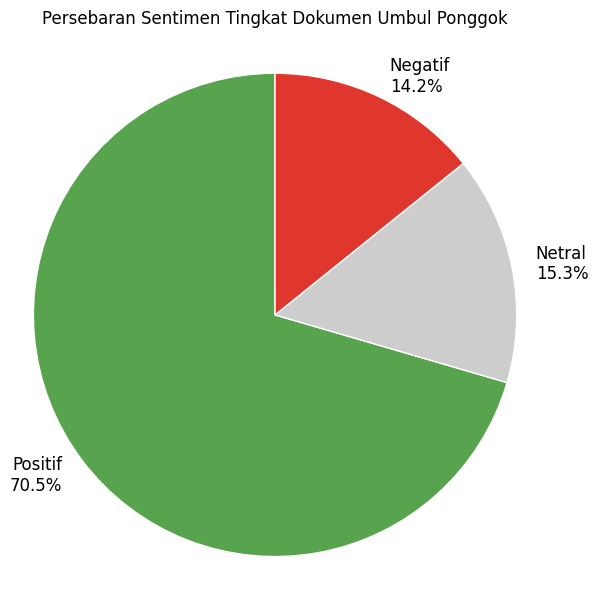

In [ ]:
# Distribusi Sentimen Data Overall
# hitung dan ubah nama kelas ke ID
counts      = df['predicted_sentiment'].map({
    'Positive':'Positif',
    'Negative':'Negatif',
    'Neutral':'Netral'
}).value_counts()

labels      = counts.index.tolist()
sizes       = counts.values
percentages = sizes / sizes.sum() * 100

# buat label dua baris: nama + persen
label_strs = [f"{lbl}\n{pct:.1f}%" for lbl,pct in zip(labels,percentages)]
colors     = [ {'Positif':'#58A34E','Negatif':'#DF362D','Netral':'#CDCDCD'}[lbl]
               for lbl in labels ]

plt.figure(figsize=(6,6))
plt.pie(sizes,
        labels=label_strs,
        colors=colors,
        startangle=90,
        wedgeprops={'edgecolor':'white','linewidth':1},
        textprops={'fontsize':12})
plt.axis('equal')
plt.title("Persebaran Sentimen Tingkat Dokumen Umbul Ponggok", pad=20)
plt.tight_layout()
plt.savefig('persebaran_sentimen_umbul_ponggok_overall_cnnlstm.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Cek jumlah per sentimen
for lbl in labels:
    print(f"{lbl:8s}: {counts[lbl]}")

Positif : 1423
Netral  : 309
Negatif : 287


memasuki kawasan lain...

## Analisis Sentimen Positif

In [ ]:
# Load data ulang kalo habis refresh/apa
df = pd.read_excel('Data_Inference/2. Umbul Ponggok/Hasil_Prediksi_CNNLSTM_Umbul_Ponggok.xlsx')

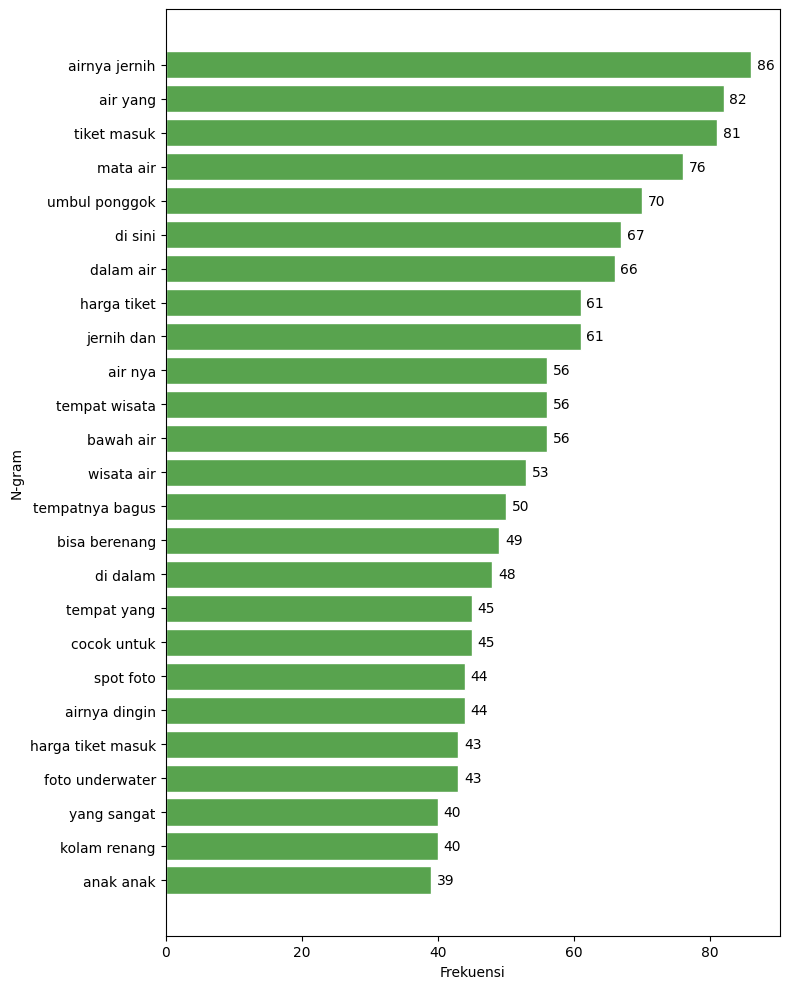

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# filter hanya ulasan Positif
pos_texts = df.loc[df['predicted_sentiment']=='Positive', 'cleaned_review'].astype(str)

# hitung n-gram
vec = CountVectorizer(
    ngram_range=(2,3),     # (1,1)=unigram, (2,2)=bigram, (1,2)=keduanya
    max_features=25,
    token_pattern=r"(?u)\b\w+\b"
)
X = vec.fit_transform(pos_texts)
counts = np.array(X.sum(axis=0)).flatten()
ngrams = vec.get_feature_names_out()

# susun DataFrame dan urutkan ascending
df_ng = pd.DataFrame({'ngram': ngrams, 'count': counts})
df_ng = df_ng.sort_values('count')

# buang n-gram tertentu kalau tidak relevan
# to_remove = ['di sini','bawah air']
# df_ng = df_ng[~df_ng['ngram'].isin(to_remove)]

# plot
plt.figure(figsize=(8,10))
bars = plt.barh(df_ng['ngram'], df_ng['count'], color='#58A34E', edgecolor='white')
for bar in bars:
    w = bar.get_width(); y = bar.get_y()+bar.get_height()/2
    plt.text(w + df_ng['count'].max()*0.01, y, str(int(w)), va='center')
plt.xlabel('Frekuensi')
plt.ylabel('N-gram')
# plt.title('Top 25 N-gram (Ulasan Positif)')
plt.tight_layout()
plt.savefig('top25_ngram_positive_umbul_ponggok_overall_cnnlstm-before.png', dpi=300, bbox_inches='tight')
plt.show()

#### Bersih-bersih lagi 🧹. ݁₊ ⊹ . ݁˖ . ݁

In [ ]:
import re

def strip_nya_and_remove_stopwords(text):
    # pastikan string
    text = str(text).lower()
    # 1) hilangkan kata berdiri sendiri yang|di|nya
    text = re.sub(r'\b(?:yang|di|nya|dan|juga|untuk|buat|dengan|dari|tapi|ke|sini|kalau|karena|kita|klo|lah|ini)\b', '', text)
    # 2) hilangkan sufiks “nya” di akhir kata (misal tempatnya → tempat)
    text = re.sub(r'(\w+?)nya\b', r'\1', text)
    # 3) rapikan spasi ganda
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Terapkan ke kolom super_cleaned_review
df['super_cleaned_review'] = df['cleaned_review'].apply(strip_nya_and_remove_stopwords)

# Contoh
print(df['super_cleaned_review'].head())


0    tempat nyaman , tempat makan banyak , parkir u...
1    sekarang udah tidak serame dulu , justru itu c...
2    air asli seger , kurang recommended anak - ana...
3                               pas lebaran ramai puol
4    tarif masuk 15k / orang kamar mandi 2k / orang...
Name: super_cleaned_review, dtype: object


In [ ]:
import re

def normalize_special(text):
    text = str(text).lower()
    text = re.sub(r'\bseger\b', 'segar', text)
    text = re.sub(r'\brenang\b', 'berenang', text)
    text = text.replace('ikan2', 'ikan')
    text = re.sub(r'ikan\s*"', 'ikan', text)
    text = re.sub(r'\bfoto\s+bawah\s+air\b', 'foto underwater', text)
    text = re.sub(r'\bbareng\s+ikan\b', 'bersama ikan', text)
    text = re.sub(r'\bsama\s+ikan\b', 'bersama ikan', text)
    text = re.sub(r'\bkolam\s+renang\b', 'kolam berenang', text)
    text = re.sub(r'\btoilet\b', 'kamar mandi', text)
    text = re.sub(r'\bwc\b', 'kamar mandi', text)
    text = re.sub(r'\bfoto\s+air\b', 'foto underwater', text)
    text = re.sub(r'\bpenyewaan\s+pelampung\b', 'sewa pelampung', text)
    text = re.sub(r'\bharus bayar\b(?!\s+lagi\b)', 'harus bayar lagi', text)
    text = re.sub(r'\bkolam\s+anak\s+anak\b', 'kolam anak', text)
    text = re.sub(r'\banak kecil\b', 'anak anak', text)
    text = re.sub(r'\bikan banyak\b', 'banyak ikan', text)
    text = re.sub(r'\bair bening\b', 'air jernih', text)
    # hanya ubah kalau TIDAK didahului 'harga'
    text = re.sub(r'(?<!harga\s)tik(et\smasuk)\b', 'harga tiket masuk', text)
    text = re.sub(r'\bharga tiket\b(?!\s*masuk)', 'harga tiket masuk', text)
    # hapus tanda kutip sisa
    text = text.replace('"', '')
    # rapikan spasi
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Terapkan tanpa merubah kolom asli
df['super_cleaned_review'] = df['super_cleaned_review'].apply(normalize_special)

In [ ]:
import re

# Compile pattern khusus “foto underwater”
pattern_underwater = re.compile(
    r'\b'
    r'(?:wahana\s+)?'
    r'(?:berfoto|foto|poto)'
    r'(?:[\s\-]*(?:foto|poto))*'
    r'(?:\s+si)?'
    r'(?:\s+di)?'
    r'\s+dalam\s+air\b',
    flags=re.IGNORECASE
)

# Fungsi terpisah untuk mengganti semua varian ke "foto underwater"
def replace_underwater(text):
    return pattern_underwater.sub('foto underwater', str(text))

df['super_cleaned_review'] = df['super_cleaned_review'].apply(replace_underwater)


## Bigram After Cleaning ૮₍ ˃ ⤙ ˂ ₎ა

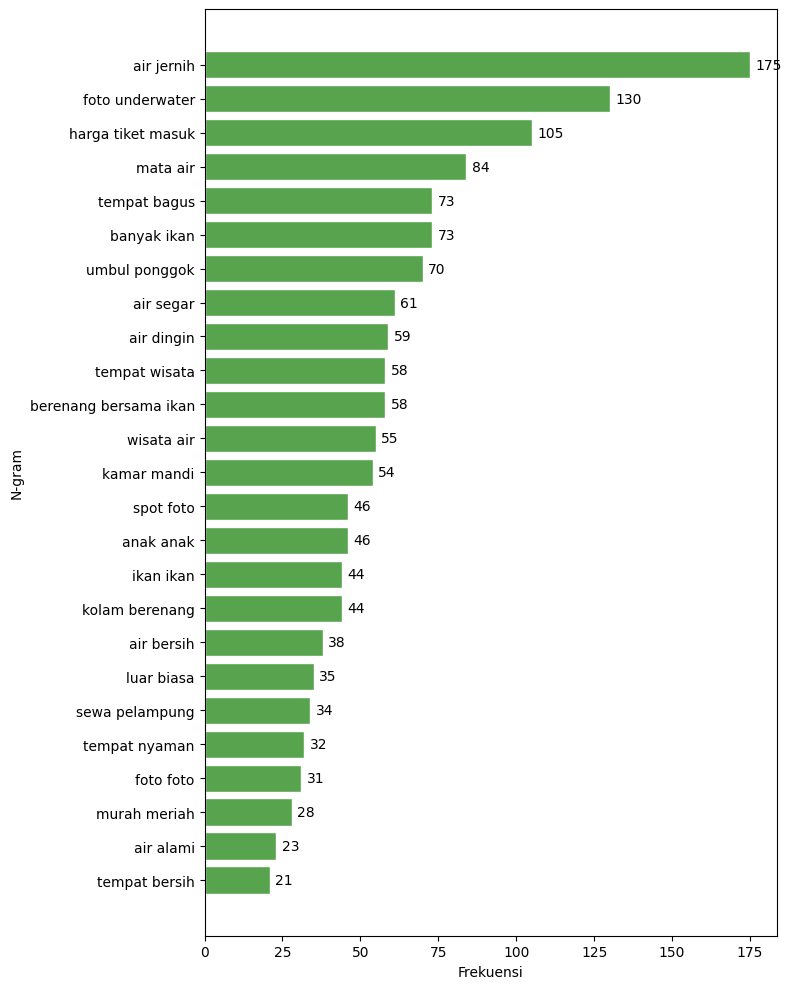

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# filter hanya ulasan Positif
pos_texts = df.loc[df['predicted_sentiment']=='Positive', 'super_cleaned_review'].astype(str)

vec = CountVectorizer(
    ngram_range=(2,3),
    max_features=None,
    token_pattern=r"(?u)\b\w+\b"
)
X = vec.fit_transform(pos_texts)
counts = np.array(X.sum(axis=0)).flatten()
ngrams = vec.get_feature_names_out()

# 2. Buat DataFrame dan urutkan menurun
df_all = pd.DataFrame({'ngram': ngrams, 'count': counts})
df_all = df_all.sort_values('count', ascending=False)

# 3. Buang yg tidak relevan
to_remove = ['di sini','bawah air', 'berenang bersama', 'harga tiket',
             'tiket masuk', 'bersama ikan', 'foto dalam', 'bisa berenang',
            'tidak bisa berenang', 'bisa foto', 'air sangat', 'tidak bisa', 'bagus air', 'dalam air', 'jernih dingin',
             'salah satu', 'dingin banget']
df_filt = df_all[~df_all['ngram'].isin(to_remove)]

# 4. Ambil 25 teratas
df_top25 = df_filt.head(25)

# 5. Untuk plotting, biasanya kita mau ascending agar barh tampil rapi
df_plot = df_top25.sort_values('count', ascending=True)

# 6. Plot
plt.figure(figsize=(8,10))
bars = plt.barh(df_plot['ngram'], df_plot['count'], color='#58A34E', edgecolor='white')
for bar in bars:
    w = bar.get_width()
    y = bar.get_y() + bar.get_height()/2
    plt.text(w + df_plot['count'].max() * 0.01, y, str(int(w)), va='center')
plt.xlabel('Frekuensi')
plt.ylabel('N-gram')
plt.tight_layout()
plt.savefig('top25_ngram_positive_umbul_ponggok_overall_cnnlstm-after.png', dpi=300, bbox_inches='tight')
plt.show()

### Cek ulasan berdasarkan top n-gram 👩🏻‍🏫

In [ ]:
import re
import pandas as pd

# buat pattern lookahead
pattern = re.compile(r'(?=(\bikan(?:[\s\-]+banyak)\b))', flags=re.IGNORECASE)

results = []
for idx, text in enumerate(pos_texts):
    # pastikan text string
    s = str(text)
    # cari semua bigram (overlapping!)
    matches = pattern.findall(s)
    if matches:
        results.append({
            'doc_index': idx,
            'count': len(matches),
            'text': s
        })

# ringkasan
num_docs = len(results)
total = sum(r['count'] for r in results)
print(f"Jumlah dokumen berisi 'anak anak': {num_docs}")
print(f"Total kemunculan 'anak anak': {total}\n")

# detail
for i, r in enumerate(results, 1):
    print(f"--- Dokumen ke-{i} (index asli {r['doc_index']}) ---")
    print(f"Kemunculan dalam dokumen ini: {r['count']}")
    print(r['text'])
    print()


Jumlah dokumen berisi 'anak anak': 23
Total kemunculan 'anak anak': 23

--- Dokumen ke-1 (index asli 62) ---
Kemunculan dalam dokumen ini: 1
dulu sekitar th 1980 saya sering lewat , memang air jernih &tidak pernah kering , ikan banyak & keluatan sangat jinak .

--- Dokumen ke-2 (index asli 108) ---
Kemunculan dalam dokumen ini: 1
seneng , air jernih segar . ikan banyak

--- Dokumen ke-3 (index asli 280) ---
Kemunculan dalam dokumen ini: 1
baru sekali kesini 4 tahun lalu itu keren bangeet saya kesini bareng temen tempat santai 2 lantai waktu itu senam dulu lantai 2 warung ada beberapa kamar mandi tidak terlalu banyak seingetku air segar jernih ada ikan banyak asri alami keren banget kalo video bawah dalem 3 meter an jadi bisa video sekalian diving sayang waktu itu tidak bisa berenang jadi dipinggiran aja dibawah ada spot foto ada jasa kalo mau pu foto dalem air ramai banget rekreasi sekolah sering kesini banyak tempat teduh sana salam sukses

--- Dokumen ke-4 (index asli 335) ---
Kemunc

#### WordCloud Sentimen Positif

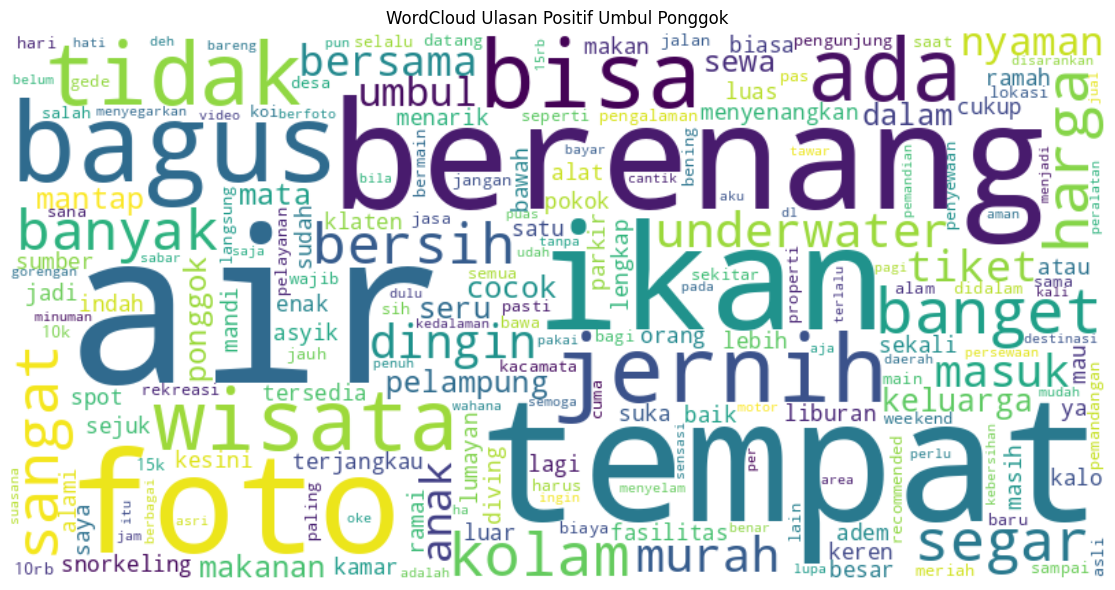

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# gabungkan semua teks positif
text_pos = " ".join(pos_texts)

# buat wordcloud
wc = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=STOPWORDS,
    collocations=False  # hindari bigram ganda
).generate(text_pos)

# tampilkan
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan Positif Umbul Ponggok')
plt.savefig('wordcloud_positive_umbul_ponggok_overall.png', dpi=300, bbox_inches='tight')
plt.tight_layout()

# Analisis Sentimen Negatif

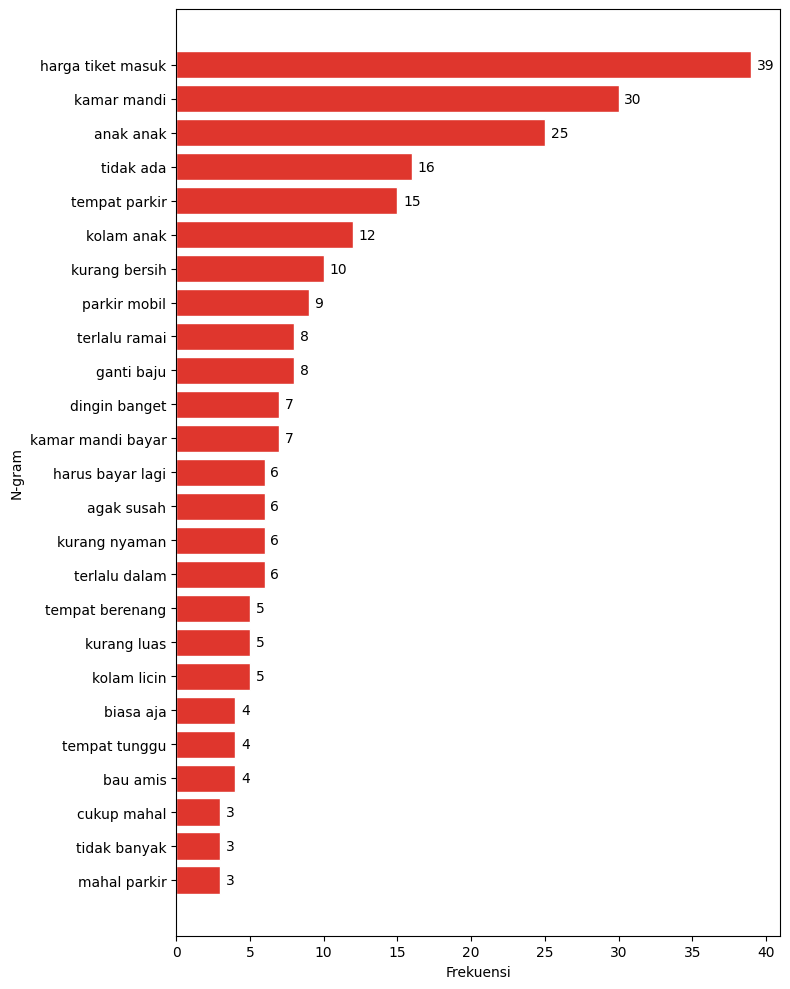

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# filter hanya ulasan Negatif
neg_texts = df.loc[df['predicted_sentiment']=='Negative', 'super_cleaned_review'].astype(str)

# hitung bigram + trigram
vec = CountVectorizer(
    ngram_range=(2,3),     # (1,1)=unigram, (2,2)=bigram, (1,2)=keduanya
    max_features=None,
    token_pattern=r"(?u)\b\w+\b"
)
X = vec.fit_transform(neg_texts)
ngrams = vec.get_feature_names_out()
counts = X.sum(axis=0).A1

# susun DataFrame dan urutkan ascending
df_all = pd.DataFrame({'ngram': ngrams, 'count': counts})
to_remove = ['di sini','bawah air','menurut saya', 'tiket masuk', 'harga tiket',
             'bersama ikan', 'air jernih', 'tempat bagus', 'harus bayar', 'bayar lagi',
            'masuk murah', 'berenang bersama', 'air segar', 'mandi bayar', 'jadi tidak',
            'ada tempat', 'bisa berenang', 'lebih baik', 'tidak terlalu', 'foto underwater', 'ha saja',
            'warga lokal', '10 000', 'mata air', 'dalam air', 'tempat cukup', 'sangat bagus',
            'kolam berenang', 'tempat wisata', 'berenang anak', '15 000', 'mandi bilas', 'ada ikan',
            'tempat duduk', 'sewa pelampung', 'tidak bisa', 'umbul ponggok', 'banyak ikan', 'tidak bisa berenang',
             '15 000', 'ada ikan', 'ada kolam', 'air dingin', 'berenang air', 'berenang anak', 'khusus anak', 'kolam anak anak',
             'mandi bilas', 'masuk 10k', 'masuk murah', 'mau foto', 'pakai pelampung', 'tiket masuk 10k', 'tidak terlalu ramai',
             'orang dewasa', 'protokol kesehatan', 'pas libur', '15 k', 'ada spot', 'ada wahana', 'baju berenang', 'air dingin banget',
             'baju mandi', 'banget cuma', 'berenang bersama', 'berenang bersama ikan', 'berenang bisa', 'berenang saya', 'biaya masuk', 'bisa foto',
             'bisa foto underwater', 'bisa sewa', 'bisa sewa pelampung', 'cuma sayang', 'ganti baju mandi', 'ikan tidak', 'kalo mau', 'spot foto',
             'wisata pemandian', 'tidak nyaman', 'masuk tidak', 'saya tidak', 'ikan sayang', 'parkir agak', 'nyaman kamar', 'mobil 10', 'mandi kencing',
             'masuk kamar mandi', 'masuk kamar', 'parkir mobil 10', 'pelampung 10', 'pengunjung tidak', 'pinggiran kolam', 'sangat disarankan', 'sayang tempat',
             'sewa pelampung 10', 'sudah ada', 'sudah banyak', 'tempat bagus', 'tempat bersih', 'tempat nyaman', 'tempat wisata pemandian', 'wisata air', 'kamar ganti',
             'ramai sekali', 'mahal ukuran', 'kolam berenang anak', 'ikan koi', 'liburan keluarga', 'makanan minuman', 'terlalu mahal', 'kurang tempat']
df_filt = df_all[~df_all['ngram'].isin(to_remove)]

# ambil 25 teratas setelah filter
df_top25 = df_filt.sort_values('count', ascending=False).head(25)

# urut lagi ascending supaya barh tampil rapi
df_plot = df_top25.sort_values('count', ascending=True)

# plot
plt.figure(figsize=(8,10))
bars = plt.barh(df_plot['ngram'], df_plot['count'], color='#DF362D', edgecolor='white')
for bar in bars:
    w = bar.get_width(); y = bar.get_y()+bar.get_height()/2
    plt.text(w + df_plot['count'].max()*0.01, y, str(int(w)), va='center')
plt.xlabel('Frekuensi')
plt.ylabel('N-gram')
# plt.title('Top 25 N-gram (Ulasan Positif)')
plt.tight_layout()
plt.savefig('top25_bigram_negative_umbul_ponggok_overall-after.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd

# ... setelah kamu punya df_all dan df_top25 seperti di kode-mu ...

# Simpan ke Excel dengan dua sheet
output_path = 'ngram_results_umbul_ponggok_neg.xlsx'
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    # semua n-gram yang terpilih (max_features=100, setelah filter)
    df_all.to_excel(writer, sheet_name='All_Ngrams', index=False)
    # top 25 n-gram untuk plotting
    # df_top25.to_excel(writer, sheet_name='Top25_Ngrams', index=False)

print(f"Hasil n-gram berhasil diekspor ke {output_path}")


Hasil n-gram berhasil diekspor ke ngram_results_umbul_ponggok_neg.xlsx


### Cek ulasan berdasarkan top n-gram 👩🏻‍🏫

In [ ]:
import re
import pandas as pd

# buat pattern lookahead
pattern = re.compile(r'(?=(\bcukup mahal\b))', flags=re.IGNORECASE)
# pattern = re.compile(r'\b10 000\b')

results = []
for idx, text in enumerate(neg_texts):
    # pastikan text string
    s = str(text)
    # cari semua bigram (overlapping!)
    matches = pattern.findall(s)
    if matches:
        results.append({
            'doc_index': idx,
            'count': len(matches),
            'text': s
        })

# ringkasan
num_docs = len(results)
total = sum(r['count'] for r in results)
print(f"Jumlah dokumen berisi 'air jernih': {num_docs}")
print(f"Total kemunculan 'air jernih': {total}\n")

# detail
for i, r in enumerate(results, 1):
    print(f"--- Dokumen ke-{i} (index asli {r['doc_index']}) ---")
    print(f"Kemunculan dalam dokumen ini: {r['count']}")
    print(r['text'])
    print()


Jumlah dokumen berisi 'air jernih': 3
Total kemunculan 'air jernih': 3

--- Dokumen ke-1 (index asli 173) ---
Kemunculan dalam dokumen ini: 1
tempat sih asih sayang harga mulai cukup mahal dibanding umbul sekitar okelaaah

--- Dokumen ke-2 (index asli 228) ---
Kemunculan dalam dokumen ini: 1
merupakan tempat wisata pemandian legendaris . tidak diketahui pasti kapan lokasi pemandian mulai dibuka atau kapan mata air ada umbul ponggok ditemukan oleh siapa pada tahun berapa kurang begitu jelas informasi . jelas mungkin bisa berumur sekitar 200 - an tahun atau tiga ratusan tahun sebelum tidak tahu pasti semenjak kakek nenek saya sudah meninggal masih kecil tempat pemandian sudah ada sudah mereka gunakan mandi ataupun mencuci ataupun ya membersihkan alat - alat rumah tangga irigasi pengairan lain sebagai . pada saat dulu saya masih kecil tempat merupakan tempat wisata pemandian menjadi favorit warga sekitar termasuk saya . sayang pada saat lokasi sudah dijadikan sebuah objek wisata komersil 

### Wordcloud Negatif

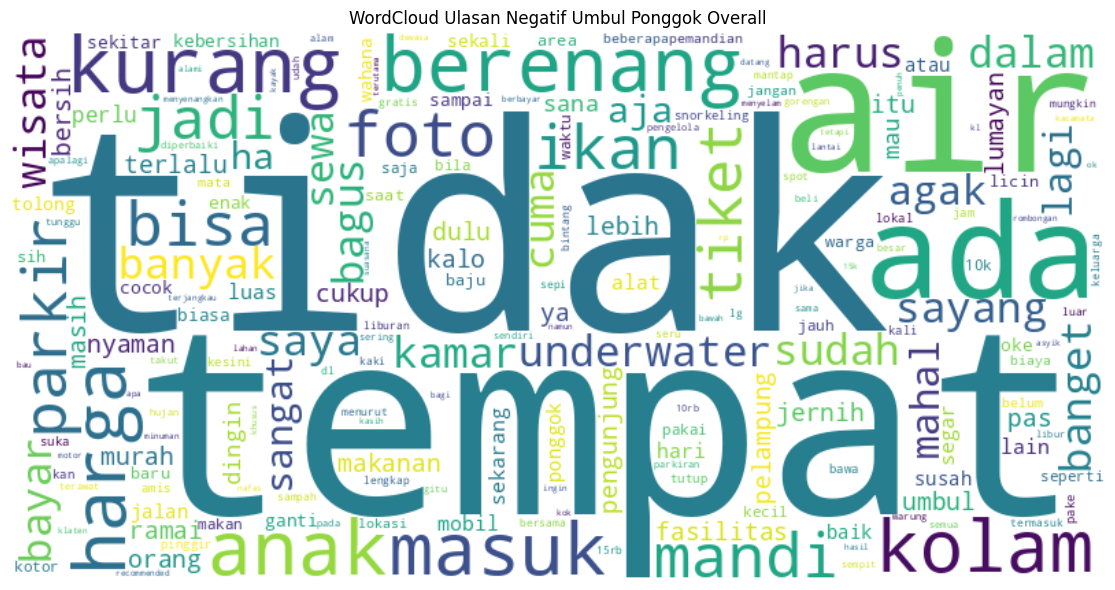

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# gabungkan semua teks negatif
text_neg= " ".join(neg_texts)

# buat wordcloud
wc = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=STOPWORDS,
    collocations=False  # hindari bigram ganda
).generate(text_neg)

# tampilkan
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan Negatif Umbul Ponggok Overall')
plt.savefig('worcloud_negative_umbul_ponggok_overall.png', dpi=300, bbox_inches='tight')
plt.tight_layout()

# Analisis Sentimen Netral

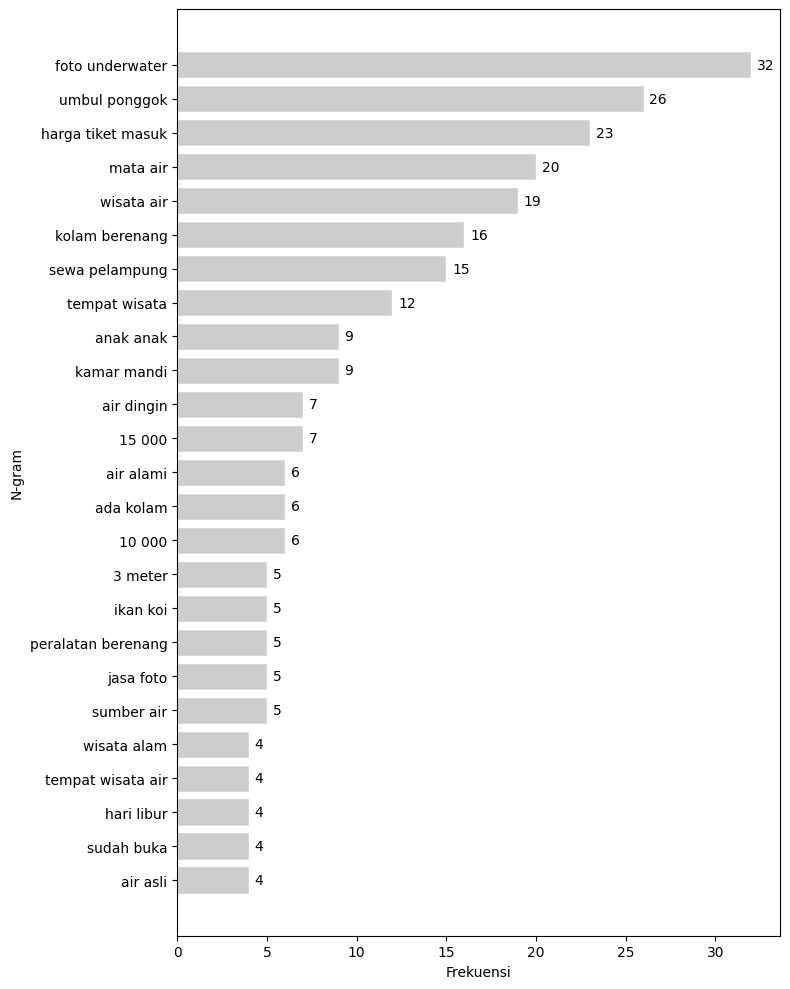

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# filter hanya ulasan Positif
neu_texts = df.loc[df['predicted_sentiment']=='Neutral', 'super_cleaned_review'].astype(str)

# hitung unigram + bigram
vec = CountVectorizer(
    ngram_range=(2,3),     # (1,1)=unigram, (2,2)=bigram, (1,2)=keduanya
    max_features=100,
    token_pattern=r"(?u)\b\w+\b"
)
X = vec.fit_transform(neu_texts)
ngrams = vec.get_feature_names_out()
counts = X.sum(axis=0).A1

# buang n-gram tertentu kalau tidak relevan
df_all = pd.DataFrame({'ngram': ngrams, 'count': counts})
to_remove = ['di sini','bawah air','menurut saya', '000 per', 'salah satu', 'bersama ikan', 'berenang bersama',
             'tiket masuk', 'harga tiket', 'masuk 15rb', 'spot foto', 'per orang', 'air jernih', 'tersedia sewa',
            'bisa foto underwater', 'air bening', 'air segar', 'tidak terlalu', 'berenang bisa', 'bisa berenang',
            'bisa foto', 'banyak ikan', 'tidak bisa', 'berenang ikan', 'bermain air', 'dalam air', 'air segar', 'berenang bisa',
             'berenang ikan', 'bermain air', 'foto foto', 'tidak bisa', 'tidak terlalu', 'air bisa', 'ikan ikan', 'per orang', 'rekreasi air',
             'rp 10', 'rp 15', 'sensasi berenang', 'rp 10 000', 'rp 15 000', 'objek wisata', 'tempat rekreasi', 'berenang bersama ikan',
             'ada ikan']
df_filt = df_all[~df_all['ngram'].isin(to_remove)]

# ambil 25 teratas setelah filter
df_top25 = df_filt.sort_values('count', ascending=False).head(25)

# urut lagi ascending supaya barh tampil rapi
df_plot = df_top25.sort_values('count', ascending=True)

# plot
plt.figure(figsize=(8,10))
bars = plt.barh(df_plot['ngram'], df_plot['count'], color='#CDCDCD', edgecolor='white')
for bar in bars:
    w = bar.get_width(); y = bar.get_y()+bar.get_height()/2
    plt.text(w + df_plot['count'].max()*0.01, y, str(int(w)), va='center')
plt.xlabel('Frekuensi')
plt.ylabel('N-gram')
# plt.title('Top 25 N-gram (Ulasan Positif)')
plt.tight_layout()
plt.savefig('top25_bigram_neutral_umbul_ponggok_overall.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd

# ... setelah kamu punya df_all dan df_top25 seperti di kode-mu ...

# Simpan ke Excel dengan dua sheet
output_path = 'ngram_results_umbul_ponggok_neu.xlsx'
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    # semua n-gram yang terpilih (max_features=100, setelah filter)
    df_all.to_excel(writer, sheet_name='All_Ngrams', index=False)
    # top 25 n-gram untuk plotting
    # df_top25.to_excel(writer, sheet_name='Top25_Ngrams', index=False)

print(f"Hasil n-gram berhasil diekspor ke {output_path}")


Hasil n-gram berhasil diekspor ke ngram_results_umbul_ponggok_neu.xlsx


### Cek ulasan berdasarkan top n-gram 👩🏻‍🏫

In [ ]:
import re
import pandas as pd

# buat pattern lookahead
pattern = re.compile(r'(?=(\bkamar mandi\b))', flags=re.IGNORECASE)

results = []
for idx, text in enumerate(neu_texts):
    # pastikan text string
    s = str(text)
    # cari semua bigram (overlapping!)
    matches = pattern.findall(s)
    if matches:
        results.append({
            'doc_index': idx,
            'count': len(matches),
            'text': s
        })

# ringkasan
num_docs = len(results)
total = sum(r['count'] for r in results)
print(f"Jumlah dokumen berisi 'anak anak': {num_docs}")
print(f"Total kemunculan 'anak anak': {total}\n")

# detail
for i, r in enumerate(results, 1):
    print(f"--- Dokumen ke-{i} (index asli {r['doc_index']}) ---")
    print(f"Kemunculan dalam dokumen ini: {r['count']}")
    print(r['text'])
    print()


Jumlah dokumen berisi 'anak anak': 9
Total kemunculan 'anak anak': 9

--- Dokumen ke-1 (index asli 13) ---
Kemunculan dalam dokumen ini: 1
ternyata wisata umbul ponggok sangat menyenangkan , selain bisa berenang mata air alami tentu saja tanpa kaporit , tersedia beberapa wahana air seperti underwater walker alias berjalan didalam air pakai helm khusus , bisa foto - foto didalam air , atau sekedar bermain air . tarif masuk rp . 15 . 000 per orang anak diatas 3 tahun . sewa pelampung tarif rp . 10 . 000 sewa snorkel rp . 15 . 000 . jasa foto underwater beda - beda tergantung property seperti pakai motor tarif rp . 200 . 000 per jam bisa 7 orang difoto bergantian . kamar mandi kamar bilas tersedia cukup banyak . parkir mobil bisa ikut lahan milik warga tarif rp . 10 . 000 per mobil .

--- Dokumen ke-2 (index asli 74) ---
Kemunculan dalam dokumen ini: 1
salah satu rekomendasi tujuan wisata tirta kabupaten klaten , akses mudah dijangkau kota solo atau yogyakarta . anda bisa foto underwater 

## Wordcloud Netral

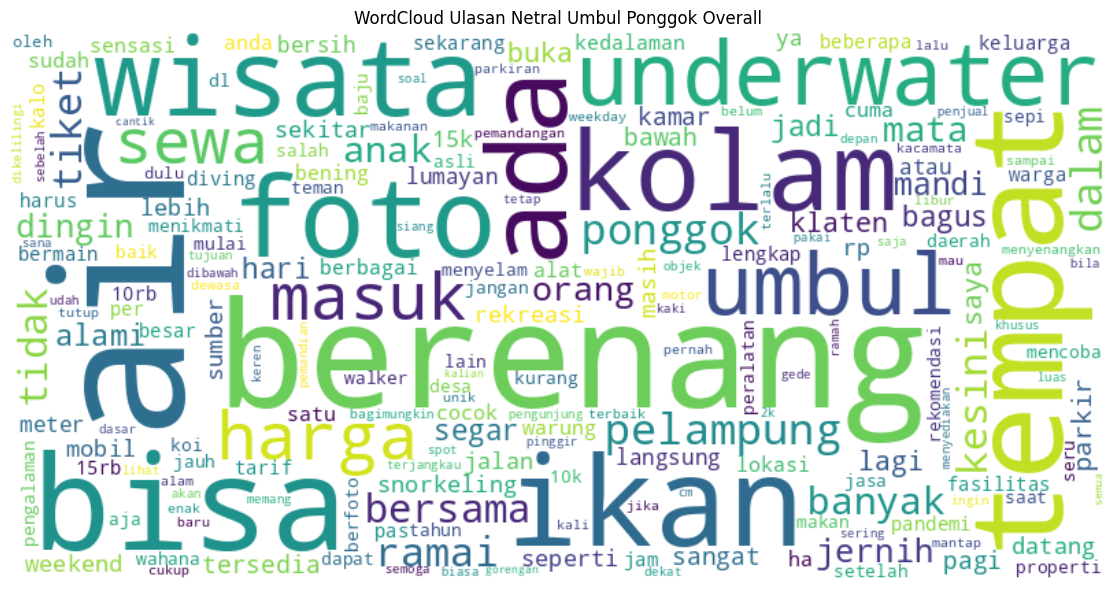

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# gabungkan semua teks negatif
text_neu= " ".join(neu_texts)

# buat wordcloud
wc = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=STOPWORDS,
    collocations=False  # hindari bigram ganda
).generate(text_neu)

# tampilkan
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Ulasan Netral Umbul Ponggok Overall')
plt.savefig('worcdloud_neutral_umbul_ponggok_overall.png', dpi=300, bbox_inches='tight')
plt.tight_layout()

## Simpan lagi file akhir yang udah dibersihin

In [ ]:
df

,review,cleaned_review,label,note,nama desa wisata,predicted_sentiment,prob_neutral,prob_positive,prob_negative,super_cleaned_review
0,"tempatnya nyaman, tempat makannya juga banyak,...","tempatnya nyaman , tempat makannya juga banyak...",inference,gatau,umbul ponggok,Positive,0.003925,0.812292,0.183783,"tempat nyaman , tempat makan , parkir udah ara..."
1,"sekarang udah g serame dulu , tapi justru itu ...","sekarang udah tidak serame dulu , tapi justru ...",inference,gatau,umbul ponggok,Negative,0.001351,0.000028,0.998621,"sekarang udah serame dulu , justru itu cari : )"
2,"airnya asli dan seger, kurang rekomended buat ...","airnya asli dan seger , kurang recommended bua...",inference,gatau,umbul ponggok,Negative,0.270282,0.106900,0.622818,"air asli segar , kurang recommended anak - ana..."
3,pas lebaran ruamene puollll,pas lebaran ramai puol,inference,gatau,umbul ponggok,Neutral,0.547093,0.082268,0.370639,pas lebaran ramai puol
4,tarif masuk 15k / orang kamar mandi 2k/ orang ...,tarif masuk 15k / orang kamar mandi 2k / orang...,inference,gatau,umbul ponggok,Positive,0.002265,0.992365,0.005370,tarif masuk 15k / orang kamar mandi 2k / orang...
...,...,...,...,...,...,...,...,...,...,...
2014,tempatnya muantab untuk rrfresing,tempatnya mantap untuk rfresing,,NaN,umbul ponggok,Positive,0.000010,0.999972,0.000018,tempat mantap rfresing
2015,"alami tempat nya,","alami tempatnya ,",,NaN,umbul ponggok,Neutral,0.800163,0.030507,0.169330,"alami tempat ,"
2016,tempat bagus,tempat bagus,,NaN,umbul ponggok,Positive,0.010895,0.973660,0.015445,tempat bagus
2017,seharusnya dibuat larangan merokok. disini kan...,seharusnya dibuat larangan merokok . di sini k...,,NaN,umbul ponggok,Negative,0.000005,0.000002,0.999993,seharus dibuat larangan merokok . kan tempat r...


In [ ]:
# Simpan ke Excel
df.to_excel('Cleaned_Hasil_Prediksi_CNNLSTM_Umbul_Ponggok.xlsx', index=False)